In [0]:
import numpy as np
import math, random
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(0)


In [0]:
# Generating a clean sine wave 
def sine(X, signal_freq=60.):
    return np.sin(2 * np.pi * (X) / signal_freq)

# Adding uniform noise
def noisy(Y, noise_range=(-0.35, 0.35)):
    noise = np.random.uniform(noise_range[0], noise_range[1], size=Y.shape)
    return Y + noise

# Create a noisy and clean sine wave 
def sample(sample_size):
    random_offset = random.randint(0, sample_size)
    X = np.arange(sample_size)
    out = sine(X + random_offset)
    inp = noisy(out)
    return inp, out


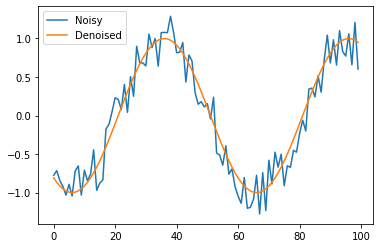

In [73]:
inp, out = sample(100)
plt.plot(inp, label='Noisy')
plt.plot(out, label ='Denoised')
plt.legend()

In [0]:
def create_dataset(n_samples=10000, sample_size=100):
    data_inp = np.zeros((n_samples, sample_size))
    data_out = np.zeros((n_samples, sample_size))
    
    for i in range(n_samples):
        sample_inp, sample_out = sample(sample_size)
        data_inp[i, :] = sample_inp
        data_out[i, :] = sample_out
    return data_inp, data_out


In [0]:

data_inp, data_out = create_dataset()
train_inp, train_out = data_inp[:8000], data_out[:8000]
test_inp, test_out = data_inp[8000:], data_out[8000:]


In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [0]:
input_dim = 1
hidden_size = 30
num_layers = 1

class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size, )
        self.act = nn.Tanh()
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        return pred

r= CustomRNN(input_dim, hidden_size, 1)

In [78]:
r

CustomRNN(
  (rnn): RNN(1, 30, batch_first=True)
  (linear): Linear(in_features=30, out_features=1, bias=True)
  (act): Tanh()
)

In [79]:
# Storing predictions per iterations to visualise later
predictions = []

optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.L1Loss()

for t in range(301):
    hidden = None
    inp = Variable(torch.Tensor(train_inp.reshape((train_inp.shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_out.reshape((train_out.shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    predictions.append(pred.data.numpy())
    loss = loss_func(pred, out)
    if t%20==0:
      print(t, loss.item())
      loss.backward()
      optimizer.step()


0 0.6492422819137573
20 0.5762184262275696
40 0.4917285442352295
60 0.36837825179100037
80 0.24512317776679993
100 0.2511880695819855
120 0.18763607740402222
140 0.12400929629802704
160 0.14065253734588623
180 0.15177229046821594
200 0.14339971542358398
220 0.12827779352664948
240 0.12559086084365845
260 0.13567158579826355
280 0.13940416276454926
300 0.13364115357398987


In [80]:
# Test loss
print(loss_func(pred_t, Variable(torch.Tensor(test_out.reshape((test_inp.shape[0], -1, 1))))).item())

0.8017184138298035


Text(0.5, 1.0, 'Sample num: 23')

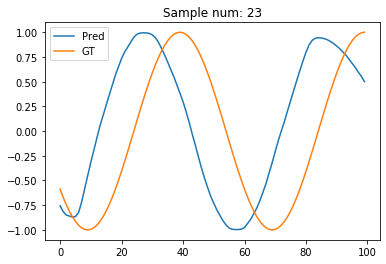

In [81]:
sample_num = 23
plt.plot(pred_t[sample_num].data.numpy(), label='Pred')
plt.plot(test_out[sample_num], label='GT')
plt.legend()
plt.title("Sample num: {}".format(sample_num))

In [82]:
bidirectional = True
if bidirectional:
    num_directions = 2
else:
    num_directions = 1
class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, 
                          batch_first=True, bidirectional=bidirectional, dropout=0.1)
        self.linear = nn.Linear(hidden_size*num_directions, output_size, )
        self.act = nn.Tanh()
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        return pred

r= CustomRNN(input_dim, hidden_size, 1)
r

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


CustomRNN(
  (rnn): RNN(1, 30, batch_first=True, dropout=0.1, bidirectional=True)
  (linear): Linear(in_features=60, out_features=1, bias=True)
  (act): Tanh()
)

In [83]:
# Storing predictions per iterations to visualise later
predictions = []

optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.L1Loss()

for t in range(301):
    hidden = None
    inp = Variable(torch.Tensor(train_inp.reshape((train_inp.shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_out.reshape((train_out.shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    predictions.append(pred.data.numpy())
    loss = loss_func(pred, out)
    if t%20==0:
        print(t, loss.item())
    loss.backward()
    optimizer.step()

0 0.6192739009857178
20 0.0935271680355072
40 0.07369626313447952
60 0.0701688900589943
80 0.06782509386539459
100 0.07631891965866089
120 0.06531763821840286
140 0.06973931938409805
160 0.05627009645104408
180 0.05666182562708855
200 0.05936925858259201
220 0.05219138786196709
240 0.05060400068759918
260 0.06276044249534607
280 0.04854019358754158
300 0.04846953973174095


In [0]:
t_inp = Variable(torch.Tensor(test_inp.reshape((test_inp.shape[0], -1, 1))), requires_grad=True)
pred_t = r(t_inp)


In [85]:

# Test loss
print(loss_func(pred_t, Variable(torch.Tensor(test_out.reshape((test_inp.shape[0], -1, 1))))).item())


0.04533657059073448


Text(0.5, 1.0, 'Sample num: 23')

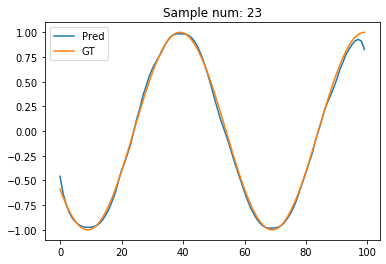

In [86]:
sample_num = 23
plt.plot(pred_t[sample_num].data.numpy(), label='Pred')
plt.plot(test_out[sample_num], label='GT')
plt.legend()
plt.title("Sample num: {}".format(sample_num))


In [87]:
bidirectional = True
if bidirectional:
    num_directions = 2
else:
    num_directions = 1
class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, 
                          batch_first=True, bidirectional=bidirectional, dropout=0.1)
        self.linear = nn.Linear(hidden_size*num_directions, output_size, )
        self.act = nn.Tanh()
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        return pred

r= CustomRNN(input_dim, hidden_size, 1)
r

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


CustomRNN(
  (rnn): GRU(1, 30, batch_first=True, dropout=0.1, bidirectional=True)
  (linear): Linear(in_features=60, out_features=1, bias=True)
  (act): Tanh()
)

In [88]:
# Storing predictions per iterations to visualise later
predictions = []

optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.L1Loss()

for t in range(201):
    hidden = None
    inp = Variable(torch.Tensor(train_inp.reshape((train_inp.shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_out.reshape((train_out.shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    predictions.append(pred.data.numpy())
    loss = loss_func(pred, out)
    if t%20==0:
        print(t, loss.item())
    loss.backward()
    optimizer.step()

0 0.6675313115119934
20 0.10457603633403778
40 0.08971744775772095
60 0.08109772205352783
80 0.06487845629453659
100 0.05066736415028572
120 0.04353632405400276
140 0.040496449917554855
160 0.03836911916732788
180 0.03480909392237663
200 0.03381653502583504


In [0]:
t_inp = Variable(torch.Tensor(test_inp.reshape((test_inp.shape[0], -1, 1))), requires_grad=True)
pred_t = r(t_inp)

In [90]:

# Test loss
print(loss_func(pred_t, Variable(torch.Tensor(test_out.reshape((test_inp.shape[0], -1, 1))))).item())

0.03420181944966316


Text(0.5, 1.0, 'Sample num: 23')

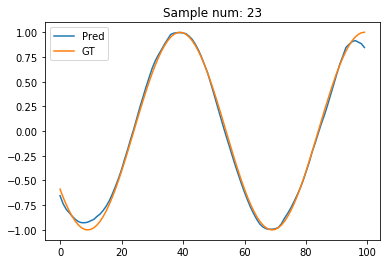

In [94]:
sample_num = 23
plt.plot(pred_t[sample_num].data.numpy(), label='Pred')
plt.plot(test_out[sample_num], label='GT')
plt.legend()
plt.title("Sample num: {}".format(sample_num))

In [0]:

for num_unknown_values in range(50):
    train_out[np.random.choice(list(range(0, 8000))), np.random.choice(list(range(0, 100)))] = np.NAN

In [96]:
np.isnan(train_out).sum()

50

In [97]:
r= CustomRNN(input_dim, 2, 1)
r

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


CustomRNN(
  (rnn): GRU(1, 2, batch_first=True, dropout=0.1, bidirectional=True)
  (linear): Linear(in_features=4, out_features=1, bias=True)
  (act): Tanh()
)

In [98]:
# Storing predictions per iterations to visualise later
predictions = []

optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.L1Loss()

for t in range(20):
    hidden = None
    inp = Variable(torch.Tensor(train_inp.reshape((train_inp.shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_out.reshape((train_out.shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    predictions.append(pred.data.numpy())
    # Create a mask to compute loss only on defined quantities
    mask = out > -1* 1e8
    loss = loss_func(pred[mask], out[mask])
    if t%20==0:
        print(t, loss.item())
    loss.backward()
    optimizer.step()

0 0.536329448223114
